In [111]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import ensemble
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import optuna

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [112]:
data = pd.read_csv('data.csv')

# Pisahkan data setelah klasifikasi, yang bukan 187
data = data[data['Cholesterol Total (mg/dL)'] != 187]

# encoding Jenis Kelamin if M = 1 and F = 0
data["Jenis Kelamin"] = data["Jenis Kelamin"].apply(lambda x: 1 if x == 'M' else 0)

# drop Tempat lahir
data.drop(['Tempat lahir', 'Responden'], axis=1, inplace=True)

# Target yang ingin diprediksi
target = data['Cholesterol Total (mg/dL)']

ori_col = data.columns

In [113]:
print(target.value_counts().to_string())

Cholesterol Total (mg/dL)
174.0    14
180.0    12
203.0    11
206.0    11
198.0    10
172.0     9
165.0     9
196.0     9
159.0     8
175.0     8
188.0     8
182.0     8
193.0     8
177.0     8
169.0     7
230.0     7
183.0     7
191.0     7
184.0     7
189.0     7
176.0     7
185.0     7
201.0     6
195.0     6
170.0     6
190.0     6
152.0     6
218.0     6
167.0     6
179.0     6
207.0     6
161.0     6
181.0     6
213.0     6
210.0     6
171.0     6
160.0     6
148.0     5
222.0     5
166.0     5
154.0     5
153.0     5
197.0     5
194.0     5
223.0     5
164.0     5
226.0     5
231.0     5
144.0     5
225.0     5
202.0     5
158.0     4
220.0     4
214.0     4
155.0     4
137.0     4
200.0     4
168.0     4
173.0     4
216.0     4
163.0     4
228.0     4
212.0     4
150.0     4
240.0     4
205.0     4
151.0     4
211.0     3
192.0     3
143.0     3
156.0     3
248.0     3
178.0     3
199.0     3
204.0     3
215.0     3
186.0     3
133.0     3
138.0     3
139.0     3
238.0     3
22

In [114]:
print(target.value_counts())

Cholesterol Total (mg/dL)
174.0    14
180.0    12
203.0    11
206.0    11
198.0    10
         ..
251.0     1
127.0     1
146.0     1
308.0     1
249.0     1
Name: count, Length: 143, dtype: int64


[]

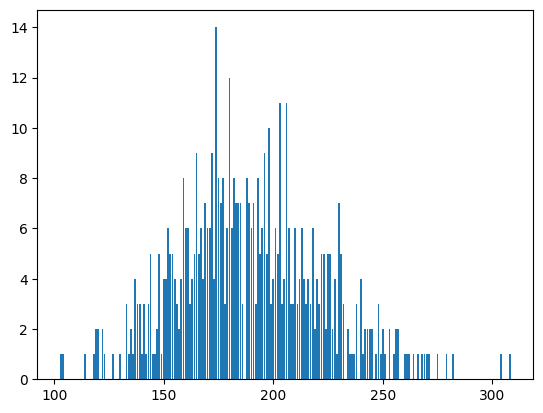

In [115]:
plt.bar(np.array(target.value_counts().index), target.value_counts().values)
plt.plot()

In [116]:
def perform_cross_validation(model, X, y, kf):
    # Initialize list to store RMSE scores for each fold
    rmse_scores = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        def rounding(pred):
            unique_target = target.unique()
            rounded_value = []
            for x in pred:
                best = unique_target[0]
                for val in unique_target:
                    if abs(val-x) < abs(best-x):
                        best = val
                rounded_value.append(best)
            return np.array(rounded_value)
        
        # Make predictions on the test set
        y_pred = rounding(model.predict(X_test))

        for idx in range(len(y_pred)):
            print(y_pred[idx], y_test.iloc[idx])
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Append RMSE to the list of scores
        rmse_scores.append(rmse)

    return rmse_scores

In [117]:
# Define the models
models = [
    XGBRegressor(),
    CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    RandomForestRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
]

# Define the number of folds for cross-validation
num_folds = 5

# Initialize KFold with stratified sampling
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for model in models:
    print(model.__class__.__name__)
    result = perform_cross_validation(model, data, target, kf)
    print(result, np.mean(result))
    # result_ori = perform_cross_validation(model, data[ori_col].drop('Cholesterol Total (mg/dL)', axis=1), target, kf)
    # print(result_ori, np.mean(result_ori))

XGBRegressor
170.0 170.0
171.0 171.0
184.0 183.0
222.0 223.0
170.0 170.0
174.0 174.0
170.0 170.0
172.0 172.0
240.0 238.0
192.0 191.0
241.0 240.0
195.0 195.0
200.0 201.0
223.0 222.0
184.0 183.0
195.0 195.0
206.0 205.0
167.0 166.0
150.0 151.0
201.0 202.0
242.0 241.0
205.0 205.0
160.0 159.0
175.0 176.0
160.0 159.0
171.0 171.0
201.0 200.0
138.0 137.0
181.0 182.0
204.0 203.0
304.0 304.0
188.0 188.0
215.0 214.0
137.0 137.0
120.0 120.0
208.0 210.0
212.0 211.0
247.0 248.0
174.0 176.0
167.0 168.0
184.0 184.0
188.0 188.0
180.0 180.0
174.0 175.0
139.0 141.0
207.0 207.0
197.0 199.0
183.0 184.0
226.0 226.0
207.0 206.0
224.0 228.0
173.0 174.0
201.0 200.0
204.0 203.0
241.0 236.0
138.0 138.0
206.0 207.0
194.0 194.0
182.0 182.0
231.0 230.0
255.0 256.0
133.0 127.0
174.0 174.0
179.0 180.0
230.0 234.0
175.0 175.0
180.0 180.0
150.0 151.0
208.0 208.0
153.0 154.0
222.0 220.0
137.0 137.0
192.0 193.0
179.0 179.0
240.0 240.0
282.0 282.0
198.0 198.0
225.0 225.0
269.0 271.0
178.0 177.0
136.0 135.0
202.0 204.0
103

CatBoostError: (The process cannot access the file because it is being used by another process.) C:/Go_Agent/pipelines/BuildMaster/catboost.git/util/system/file.cpp:857: can't open "catboost_info\\learn\\events.out.tfevents" with mode WrOnly|CreateAlways|Seq (0x00000034)

In [ ]:
len(data)

549

In [ ]:
(549*31.15293945183874)/1339

12.772937833502217

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# Calculate the feature selection
feature_selection = mutual_info_regression(data, target)

# Print the feature selection scores
for feature, score in zip(data.columns, feature_selection):
    print(f"Feature: {feature}, Score: {score}")



Feature: Jenis Kelamin, Score: 0.02312498389947404
Feature: Usia, Score: 0.0
Feature: Tekanan darah  (S), Score: 0.033896401814100585
Feature: Tekanan darah  (D), Score: 0.008966544105550422
Feature: Tinggi badan (cm), Score: 0.034829131943082015
Feature: Berat badan (kg), Score: 0.0060798853915886575
Feature: IMT (kg/m2), Score: 0.08969712684241804
Feature: Lingkar perut (cm), Score: 0.0
Feature: Glukosa Puasa (mg/dL), Score: 0.03766891544331319
Feature: Trigliserida (mg/dL), Score: 0.04768975688514754
Feature: Fat, Score: 0.0
Feature: Visceral Fat, Score: 0.0
Feature: Masa Kerja, Score: 0.024709703863659005


In [ ]:
data

,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja
9,1,20.0,120.0,80.0,179.0,80.95,25.26,90.0,80.0,89.0,26.4,6.0,2.00
48,0,22.0,120.0,80.0,163.0,51.35,19.32,68.0,84.0,89.0,29.8,2.0,0.00
52,0,22.0,90.0,70.0,155.5,50.70,21.00,65.0,84.0,53.0,26.4,6.0,0.00
54,0,22.0,100.0,60.0,150.0,42.40,18.84,64.0,84.0,61.0,31.1,2.0,0.00
108,0,23.0,110.0,70.0,166.0,56.60,20.54,74.0,84.0,147.0,26.4,6.0,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,72.0,23.8,11.0,6.00
1335,0,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,105.0,38.1,9.0,6.15
1336,0,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,78.0,35.3,8.0,26.00
1337,1,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,98.0,17.1,5.0,4.30


In [ ]:
target

9       170.0
48      247.0
52      171.0
54      144.0
108     256.0
        ...  
1334    169.0
1335    199.0
1336    177.0
1337    244.0
1338    180.0
Name: Cholesterol Total (mg/dL), Length: 549, dtype: float64

In [ ]:
np.array([elm for elm in sorted(target.unique())])

array([103., 104., 114., 118., 119., 120., 122., 123., 127., 130., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.,
       167., 168., 169., 170., 171., 172., 173., 174., 175., 176., 177.,
       178., 179., 180., 181., 182., 183., 184., 185., 186., 188., 189.,
       190., 191., 192., 193., 194., 195., 196., 197., 198., 199., 200.,
       201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211.,
       212., 213., 214., 215., 216., 217., 218., 219., 220., 221., 222.,
       223., 224., 225., 226., 227., 228., 229., 230., 231., 232., 234.,
       235., 236., 237., 238., 240., 241., 242., 243., 244., 245., 247.,
       248., 249., 250., 251., 253., 255., 256., 257., 260., 261., 262.,
       264., 266., 268., 269., 270., 271., 275., 279., 282., 304., 308.])

In [118]:
def plotter(data, target):
    from math import ceil
    fig, ax = plt.subplots(ceil(len(data.columns)/5), 5, figsize = (35, 20))
    ax = ax.flatten()

    # Iterate over the columns
    for i, column in enumerate(data.columns):
        ax[i].set_title(f'{column} vs {target}')
        ax[i].scatter(data[column], data[target])


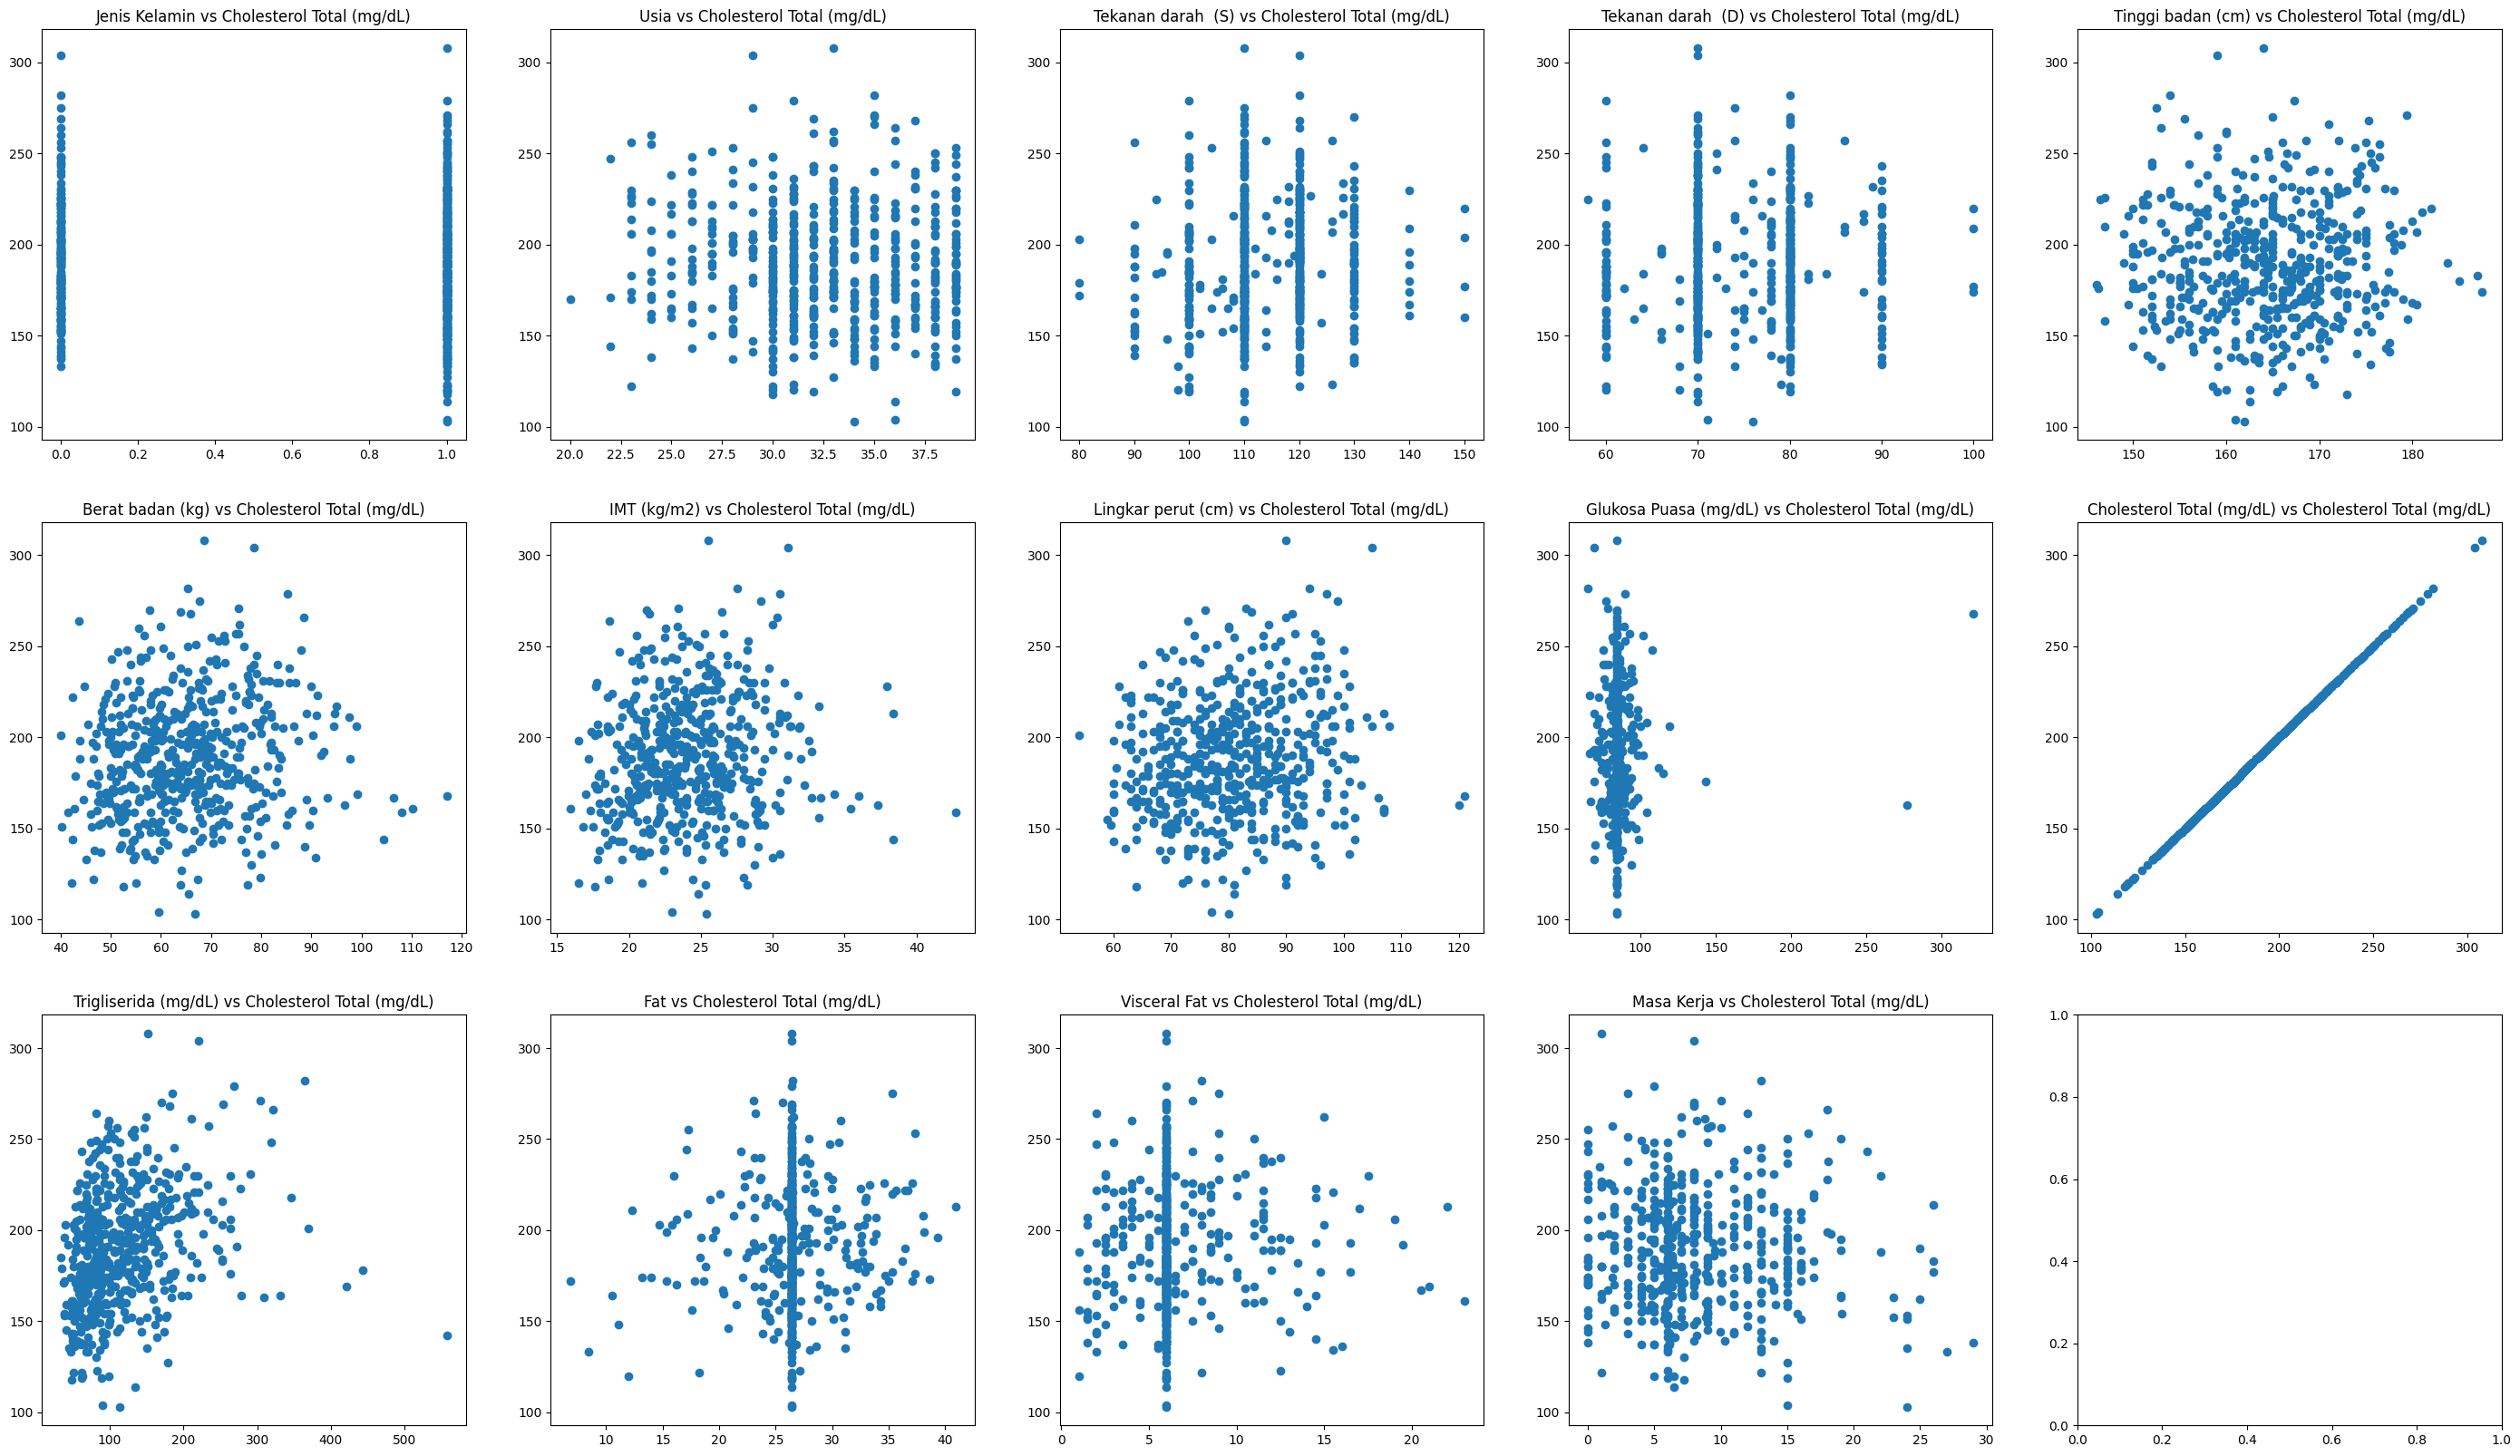

In [120]:
plotter(data, 'Cholesterol Total (mg/dL)')